# Requirements

In [161]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jsonschema.exceptions import best_match
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error,r2_score

In [162]:
df = pd.read_csv("amazon_stock_price.csv")

In [163]:
df.head()

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000


## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **close price** for the Amazon stock. To accomplish this, you will use data from the preceding 7 days, and past statistics. 


## The Amazon Stock Price Dataset

The dataset comprises the following columns:
- date - the date of the recorded price
- open - the open price of the stock
- high - the high price of the stock
- low - the low price of the stock
- volume - the volume trades
- close - the close price of the stock

Target:
close

Load the dataset into a `pandas` data frame.

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685 entries, 0 to 6684
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6685 non-null   object 
 1   open    6685 non-null   float64
 2   high    6685 non-null   float64
 3   low     6685 non-null   float64
 4   close   6685 non-null   float64
 5   volume  6685 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 313.5+ KB


Explore the dataset using visualizations of your choice.

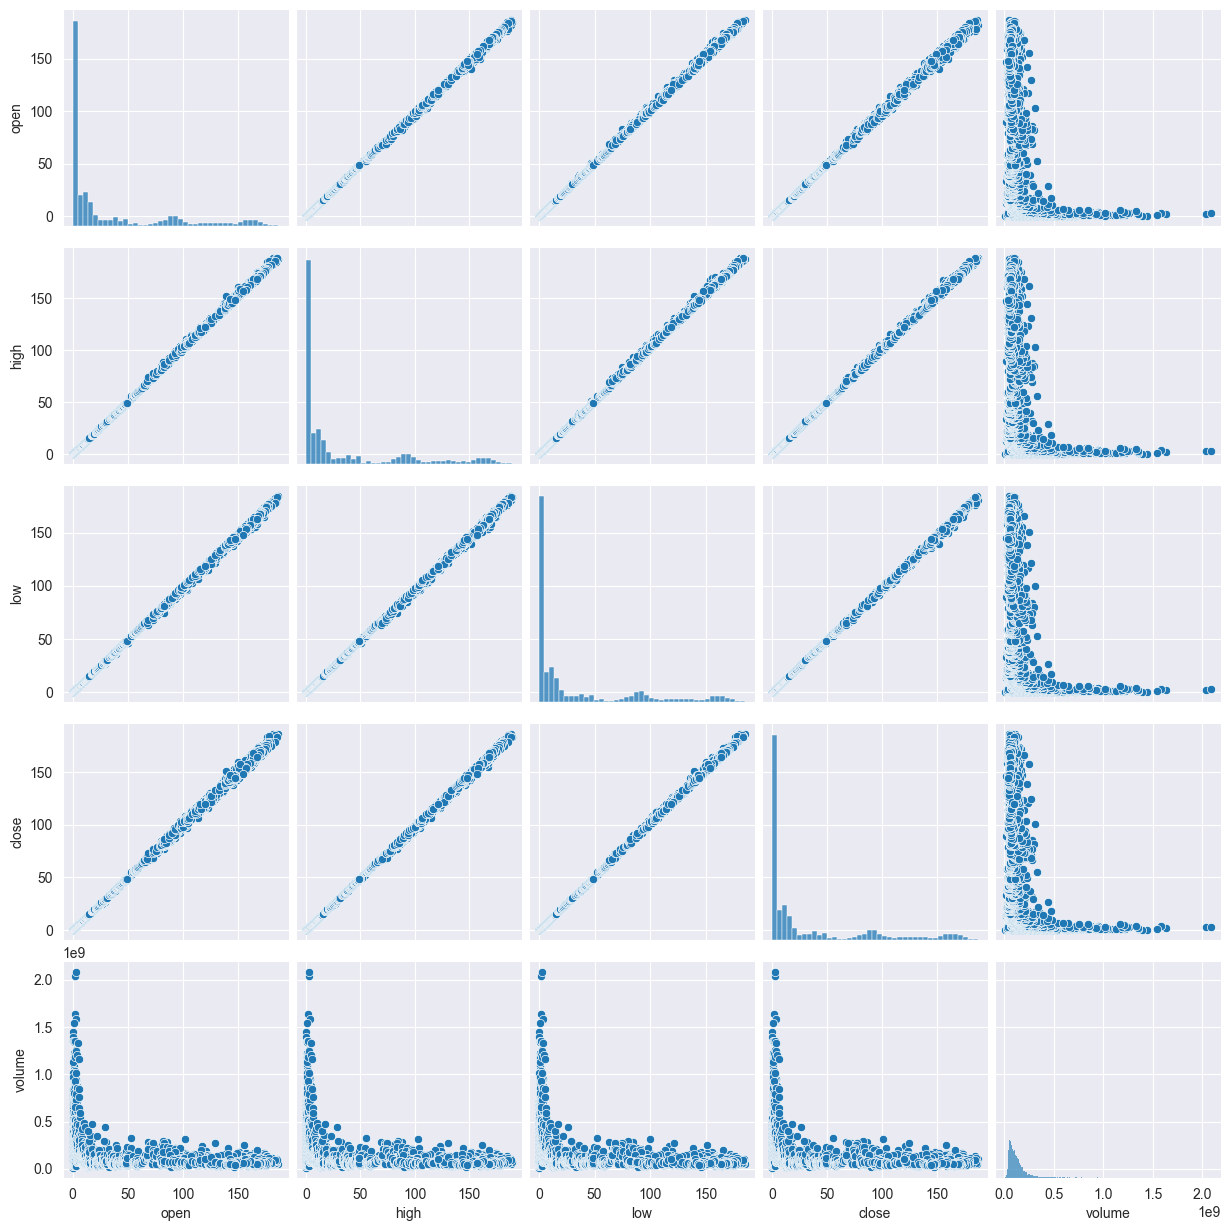

In [165]:
sns.pairplot(df)

In [166]:
correlation_matrix = df[['close', 'open', 'high', 'low', 'volume']].corr()
print(correlation_matrix)


           close      open      high       low    volume
close   1.000000  0.999790  0.999901  0.999906 -0.279841
open    0.999790  1.000000  0.999914  0.999897 -0.279792
high    0.999901  0.999914  1.000000  0.999875 -0.278699
low     0.999906  0.999897  0.999875  1.000000 -0.280974
volume -0.279841 -0.279792 -0.278699 -0.280974  1.000000


# Feauture Extraction
Select the relevant features for prediction and apply a lag of up to 7 days to each chosen feature

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [167]:
df['date'] = pd.to_datetime(df['date'])

In [168]:
df = df.sort_values(by='date')

In [169]:
df.head(10)

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000
5,1997-05-22,0.0719,0.0724,0.0656,0.0698,235536000
6,1997-05-23,0.0703,0.0760,0.0667,0.0750,318744000
7,1997-05-27,0.0755,0.0823,0.0729,0.0792,173952000
8,1997-05-28,0.0812,0.0818,0.0766,0.0766,91488000
9,1997-05-29,0.0771,0.0771,0.0740,0.0753,69456000


In [170]:
features_to_shift = ['open', 'high', 'low', 'close']
for feature in features_to_shift:
    for lag in range(1,8):
        df[f'{feature}_{lag}'] = df[feature].shift(lag)
df = df.dropna(axis=0, how='any')
df.head()

,date,open,high,low,close,volume,open_1,open_2,open_3,open_4,...,low_5,low_6,low_7,close_1,close_2,close_3,close_4,close_5,close_6,close_7
7,1997-05-27,0.0755,0.0823,0.0729,0.0792,173952000,0.0703,0.0719,0.0818,0.0865,...,0.0812,0.0854,0.0964,0.0750,0.0698,0.0714,0.0818,0.0854,0.0865,0.0979
8,1997-05-28,0.0812,0.0818,0.0766,0.0766,91488000,0.0755,0.0703,0.0719,0.0818,...,0.0818,0.0812,0.0854,0.0792,0.0750,0.0698,0.0714,0.0818,0.0854,0.0865
9,1997-05-29,0.0771,0.0771,0.0740,0.0753,69456000,0.0812,0.0755,0.0703,0.0719,...,0.0688,0.0818,0.0812,0.0766,0.0792,0.0750,0.0698,0.0714,0.0818,0.0854
10,1997-05-30,0.0750,0.0755,0.0740,0.0750,51888000,0.0771,0.0812,0.0755,0.0703,...,0.0656,0.0688,0.0818,0.0753,0.0766,0.0792,0.0750,0.0698,0.0714,0.0818
11,1997-06-02,0.0755,0.0766,0.0750,0.0755,11832000,0.0750,0.0771,0.0812,0.0755,...,0.0667,0.0656,0.0688,0.0750,0.0753,0.0766,0.0792,0.0750,0.0698,0.0714


In [171]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df = df.drop(columns=['date'])
df.head()

,open,high,low,close,volume,open_1,open_2,open_3,open_4,open_5,...,close_2,close_3,close_4,close_5,close_6,close_7,year,month,day,day_of_week
7,0.0755,0.0823,0.0729,0.0792,173952000,0.0703,0.0719,0.0818,0.0865,0.0880,...,0.0698,0.0714,0.0818,0.0854,0.0865,0.0979,1997,5,27,1
8,0.0812,0.0818,0.0766,0.0766,91488000,0.0755,0.0703,0.0719,0.0818,0.0865,...,0.0750,0.0698,0.0714,0.0818,0.0854,0.0865,1997,5,28,2
9,0.0771,0.0771,0.0740,0.0753,69456000,0.0812,0.0755,0.0703,0.0719,0.0818,...,0.0792,0.0750,0.0698,0.0714,0.0818,0.0854,1997,5,29,3
10,0.0750,0.0755,0.0740,0.0750,51888000,0.0771,0.0812,0.0755,0.0703,0.0719,...,0.0766,0.0792,0.0750,0.0698,0.0714,0.0818,1997,5,30,4
11,0.0755,0.0766,0.0750,0.0755,11832000,0.0750,0.0771,0.0812,0.0755,0.0703,...,0.0753,0.0766,0.0792,0.0750,0.0698,0.0714,1997,6,2,0


In [172]:
# scaler = MinMaxScaler()
# df[['volume']] = scaler.fit_transform(df[['volume']])

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [173]:
X = df.drop(columns='close')
Y = df['close']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=False)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [174]:
model1 = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model1.fit(X_train,Y_train)
y_pred_1 = model1.predict(X_test)

In [175]:
mse = mean_squared_error(Y_test, y_pred_1)
mae = mean_absolute_error(Y_test, y_pred_1)
r2 = r2_score(Y_test, y_pred_1)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 1866.05
Mean Absolute Error (MAE): 31.75
R-squared (R2): -0.83


Use the trained model to make predictions for the test set.

In [176]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [177]:
# Write your code here. Add as many boxes as you need.

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [178]:
model2 = XGBRegressor(n_estimators=200, random_state=42,learning_rate=0.2)

Use the trained model to make predictions for the test set.

In [179]:
model2.fit(X_train,Y_train)
y_pred_2 = model2.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [180]:
mse = mean_squared_error(Y_test, y_pred_2)
mae = mean_absolute_error(Y_test, y_pred_2)
r2 = r2_score(Y_test, y_pred_2)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 2103.08
Mean Absolute Error (MAE): 34.95
R-squared (R2): -1.07
